In [8]:
!pip install -q tensorflow keras numpy pillow h5py torch opencv-python scikit-learn
!pip install -q keras-applications0
!pip install -q keras-preprocessing
!pip install -q keras-resnet
!pip install -q scikit-learn numpy

ERROR: Could not find a version that satisfies the requirement keras-applications0 (from versions: none)
ERROR: No matching distribution found for keras-applications0


In [2]:
import json
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

def load_and_preprocess_data(json_path):
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    metadata = data['metadata']
    action = metadata['inspect']['action']
    
    X = []
    y = []
    
    for annotation in data['annotations']:
        frame_keypoints = []
        for i in range(1, 16):
            kp = annotation['keypoints'].get(str(i))
            if kp:
                frame_keypoints.extend([kp['x'], kp['y']])
            else:
                frame_keypoints.extend([0, 0])
        X.append(frame_keypoints)
        y.append(action)
    
    return np.array(X), y, metadata

def prepare_dataset(json_files):
    X_all = []
    y_all = []
    all_metadata = []
    
    for json_file in json_files:
        X, y, metadata = load_and_preprocess_data(json_file)
        X_all.extend(X)
        y_all.extend(y)
        all_metadata.append(metadata)
    
    X_all = np.array(X_all)
    
    unique_actions = list(set(y_all))
    action_to_index = {action: index for index, action in enumerate(unique_actions)}
    y_encoded = [action_to_index[action] for action in y_all]
    
    return X_all, np.array(y_encoded), all_metadata, unique_actions

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(hidden_size, 16)
        self.fc2 = nn.Linear(16, num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

# JSON 파일 경로 리스트
json_files = ['E:/LSTN_test/data/ARCH/20201028_cat-arch-000156.mp4.json']

X, y, metadata, action_classes = prepare_dataset(json_files)

print(f"총 샘플 수: {len(X)}")

if len(X) == 0:
    print("처리할 수 있는 이미지가 없습니다. 프로그램을 종료합니다.")
    exit()

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# PyTorch 텐서로 변환
X_train = torch.FloatTensor(X_train).unsqueeze(1)  # (batch_size, 1, feature_size)
X_test = torch.FloatTensor(X_test).unsqueeze(1)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# 데이터로더 생성
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 모델 초기화
input_size = X.shape[1]
hidden_size = 64
num_layers = 2
num_classes = len(action_classes)

model = LSTMModel(input_size, hidden_size, num_layers, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# 학습
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    # 검증
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
        
        accuracy = 100 * correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy:.2f}%')

# 최종 테스트
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
    
    accuracy = 100 * correct / total
    print(f'테스트 정확도: {accuracy:.2f}%')

# 메타데이터 활용 예시
print("\n메타데이터 예시:")
print(json.dumps(metadata[0], indent=2, ensure_ascii=False))

print("\n행동 클래스:")
for i, action in enumerate(action_classes):
    print(f"{i}: {action}")

PermissionError: [Errno 13] Permission denied: 'E:/LSTN_test/data/ARCH'

In [12]:
# 모델 평가
loss, accuracy = model.evaluate(X_test, y_test)
print(f"테스트 정확도: {accuracy}")
# 모델 예측
predictions = model.predict(X_test)
predicted_behaviors = np.argmax(predictions, axis=1)

# 예측 결과 출력
print("\n예측 결과:")
for i, behavior in enumerate(predicted_behaviors):
    print(f"{i}: {behavior}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 0.0000e+00
테스트 정확도: 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

예측 결과:
0: 0
1: 0
2: 0
3: 0
4: 0


In [16]:
import torch
import torch.nn as nn
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM, Dense
import numpy as np

def keras_to_pytorch(keras_model):
    class PyTorchLSTM(nn.Module):
        def __init__(self, input_size, hidden_size, num_layers, num_classes):
            super(PyTorchLSTM, self).__init__()
            self.hidden_size = hidden_size
            self.num_layers = num_layers
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
            self.fc = nn.Linear(hidden_size, num_classes)
        
        def forward(self, x):
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
            out, _ = self.lstm(x, (h0, c0))
            out = self.fc(out[:, -1, :])
            return out

    input_size = keras_model.input_shape[-1]
    hidden_size = keras_model.layers[0].units
    num_layers = sum(1 for layer in keras_model.layers if isinstance(layer, LSTM))
    num_classes = keras_model.output_shape[-1]

    pytorch_model = PyTorchLSTM(input_size, hidden_size, num_layers, num_classes)
    
    # Keras 모델의 가중치를 PyTorch 모델로 복사
    for i, layer in enumerate(keras_model.layers):
        if isinstance(layer, LSTM):
            weights = layer.get_weights()
            if len(weights) == 3:  # Keras LSTM은 보통 3개의 가중치 배열을 가집니다
                # 입력 가중치, 순환 가중치, 편향
                input_weights, recurrent_weights, bias = weights
                pytorch_model.lstm.weight_ih_l0.data = torch.FloatTensor(input_weights.T)
                pytorch_model.lstm.weight_hh_l0.data = torch.FloatTensor(recurrent_weights.T)
                # Keras의 편향은 입력 게이트, 망각 게이트, 셀 게이트, 출력 게이트 순서입니다
                # PyTorch는 입력 게이트, 망각 게이트, 셀 게이트, 출력 게이트 순서입니다
                pytorch_model.lstm.bias_ih_l0.data = torch.FloatTensor(bias[:hidden_size*4])
                pytorch_model.lstm.bias_hh_l0.data = torch.FloatTensor(bias[hidden_size*4:])
        elif isinstance(layer, Dense):
            weights, bias = layer.get_weights()
            pytorch_model.fc.weight.data = torch.FloatTensor(weights.T)
            pytorch_model.fc.bias.data = torch.FloatTensor(bias)

    return pytorch_model

# Keras 모델을 PyTorch 모델로 변환
pytorch_model = keras_to_pytorch(model)

# PyTorch 모델 저장
torch.save(pytorch_model.state_dict(), 'lstm_model.pt')

print("PyTorch 모델이 'lstm_model.pt' 파일로 저장되었습니다.")

PyTorch 모델이 'lstm_model.pt' 파일로 저장되었습니다.


In [22]:
import torch

# 저장된 모델 로드
saved_model = torch.load('lstm_model.pt')

# 모델 상태 확인
print("모델 상태 키:")
for key in saved_model.keys():
    print(key)

print("\n각 레이어의 형태:")
for key, value in saved_model.items():
    print(f"{key}: {value.shape}")

# LSTM 레이어의 입력 및 은닉 상태 크기 확인
if 'lstm.weight_ih_l0' in saved_model:
    input_size = saved_model['lstm.weight_ih_l0'].shape[1]
    hidden_size = saved_model['lstm.weight_ih_l0'].shape[0] // 4
    print(f"\nLSTM 입력 크기: {input_size}")
    print(f"LSTM 은닉 상태 크기: {hidden_size}")

# LSTM 레이어 수 확인
num_layers = sum(1 for key in saved_model if key.startswith('lstm.weight_ih_l'))
print(f"LSTM 레이어 수: {num_layers}")

# 출력 레이어(fc) 크기 확인
if 'fc.weight' in saved_model:
    output_size = saved_model['fc.weight'].shape[0]
    print(f"출력 크기: {output_size}")

모델 상태 키:
lstm.weight_ih_l0
lstm.weight_hh_l0
lstm.bias_ih_l0
lstm.bias_hh_l0
lstm.weight_ih_l1
lstm.weight_hh_l1
lstm.bias_ih_l1
lstm.bias_hh_l1
fc.weight
fc.bias

각 레이어의 형태:
lstm.weight_ih_l0: torch.Size([128, 64])
lstm.weight_hh_l0: torch.Size([128, 32])
lstm.bias_ih_l0: torch.Size([128])
lstm.bias_hh_l0: torch.Size([0])
lstm.weight_ih_l1: torch.Size([256, 64])
lstm.weight_hh_l1: torch.Size([256, 64])
lstm.bias_ih_l1: torch.Size([256])
lstm.bias_hh_l1: torch.Size([256])
fc.weight: torch.Size([1, 16])
fc.bias: torch.Size([1])

LSTM 입력 크기: 64
LSTM 은닉 상태 크기: 32
LSTM 레이어 수: 2
출력 크기: 1


C:\Users\Administrator\AppData\Local\Temp\ipykernel_12192\148980449.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_model = torch.load('lstm_model.pt')


In [2]:
import cv2
import os
import re

# 이미지 파일이 있는 디렉토리 경로
이미지_디렉토리 = r'E:\LSTN_test\data\img\20201028_cat-arch-000156.mp4'

# 출력할 동영상 파일 이름
출력_비디오 = 'test.mp4'

# 프레임 번호를 추출하는 함수
def get_frame_number(filename):
    match = re.search(r'frame_(\d+)_', filename)
    return int(match.group(1)) if match else -1

# 이미지 파일 목록 가져오기 및 정렬
이미지_파일들 = [f for f in os.listdir(이미지_디렉토리) if f.endswith('.jpg') or f.endswith('.png')]
이미지_파일들.sort(key=get_frame_number)  # 프레임 번호 기준으로 정렬

if not 이미지_파일들:
    print("이미지 파일을 찾을 수 없습니다.")
    exit()

# 첫 번째 이미지로 비디오 writer 초기화
첫_이미지_경로 = os.path.join(이미지_디렉토리, 이미지_파일들[0])
첫_이미지 = cv2.imread(첫_이미지_경로)

if 첫_이미지 is None:
    print(f"이미지를 열 수 없습니다: {첫_이미지_경로}")
    exit()

높이, 너비, _ = 첫_이미지.shape
fps = 15  # 초당 프레임 수 설정

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
비디오_writer = cv2.VideoWriter(출력_비디오, fourcc, fps, (너비, 높이))

# 각 이미지를 비디오 프레임으로 추가
for 이미지_파일 in 이미지_파일들:
    이미지_경로 = os.path.join(이미지_디렉토리, 이미지_파일)
    프레임 = cv2.imread(이미지_경로)
    
    if 프레임 is None:
        print(f"이미지를 열 수 없습니다: {이미지_경로}")
        continue
    
    비디오_writer.write(프레임)

# 비디오 writer 해제
비디오_writer.release()

print(f"동영상이 성공적으로 생성되었습니다: {출력_비디오}")

처리된 이미지: frame_0_timestamp_0.jpg
처리된 이미지: frame_12_timestamp_800.jpg
처리된 이미지: frame_15_timestamp_1000.jpg
처리된 이미지: frame_102_timestamp_6800.jpg
처리된 이미지: frame_105_timestamp_7000.jpg
처리된 이미지: frame_108_timestamp_7200.jpg
처리된 이미지: frame_111_timestamp_7400.jpg
처리된 이미지: frame_114_timestamp_7600.jpg
처리된 이미지: frame_117_timestamp_7800.jpg
처리된 이미지: frame_120_timestamp_8000.jpg
처리된 이미지: frame_123_timestamp_8200.jpg
처리된 이미지: frame_126_timestamp_8400.jpg
처리된 이미지: frame_129_timestamp_8600.jpg
처리된 이미지: frame_132_timestamp_8800.jpg
처리된 이미지: frame_135_timestamp_9000.jpg
처리된 이미지: frame_138_timestamp_9200.jpg
처리된 이미지: frame_141_timestamp_9400.jpg
처리된 이미지: frame_144_timestamp_9600.jpg
처리된 이미지: frame_147_timestamp_9800.jpg
처리된 이미지: frame_150_timestamp_10000.jpg
처리된 이미지: frame_153_timestamp_10200.jpg
처리된 이미지: frame_156_timestamp_10400.jpg
처리된 이미지: frame_159_timestamp_10600.jpg
처리된 이미지: frame_162_timestamp_10800.jpg
처리된 이미지: frame_165_timestamp_11000.jpg
동영상이 성공적으로 생성되었습니다: test.mp4


## 0929 데이터 전처리

In [4]:
import numpy as np
import json
import os

def convert_json_to_lstm_sequence(json_file):
    with open(json_file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    sequence = []
    for annotation in data['annotations']:
        frame_features = []
        
        # Bounding box
        bbox = annotation['bounding_box']
        frame_features.extend([bbox['x'], bbox['y'], bbox['width'], bbox['height']])
        
        # Keypoints
        for i in range(1, 16):
            kp = annotation['keypoints'].get(str(i))
            if kp:
                frame_features.extend([kp['x'], kp['y']])
            else:
                frame_features.extend([0, 0])
        
        sequence.append(frame_features)
    
    # 메타데이터에서 레이블 정보 추출
    label = data['metadata']['action']
    
    return sequence, label

def process_all_json_files(base_folder, output_folder):
    all_sequences = []
    all_labels = []
    
    for root, dirs, files in os.walk(base_folder):
        for file in files:
            if file.endswith('.json'):
                json_file_path = os.path.join(root, file)
                sequence, label = convert_json_to_lstm_sequence(json_file_path)
                all_sequences.append(sequence)
                all_labels.append(label)
    
    # 가장 긴 시퀀스의 길이 찾기
    max_seq_length = max(len(seq) for seq in all_sequences)
    
    # 패딩 적용
    padded_sequences = []
    for seq in all_sequences:
        padded_seq = seq + [[0] * len(seq[0])] * (max_seq_length - len(seq))
        padded_sequences.append(padded_seq)
    
    # 데이터를 NumPy 배열로 저장
    np.save(os.path.join(output_folder, 'lstm_sequences.npy'), np.array(padded_sequences))
    np.save(os.path.join(output_folder, 'lstm_labels.npy'), np.array(all_labels))

# 실행
base_folder = r"G:\workspace\test\ARCH"
output_folder = r"G:\workspace\LSTN_test\models"

os.makedirs(output_folder, exist_ok=True)
process_all_json_files(base_folder, output_folder)
print("데이터 변환 완료")

데이터 변환 완료


In [12]:
import numpy as np

labels_path = r"G:\workspace\LSTN_test\models\lstm_labels.npy"
labels = np.load(labels_path, allow_pickle=True)

print("라벨 샘플:")
print(labels[:10])  # 처음 10개 라벨 출력
print("\n고유한 라벨:")
print(np.unique(labels))

라벨 샘플:
['허리를 아치로 세움' '허리를 아치로 세움' '허리를 아치로 세움' '허리를 아치로 세움' '허리를 아치로 세우는 동작'
 '허리를 아치로 세움' '허리를 아치로 세우는 동작' '허리를 아치로 세우는 동작' '허리를 아치로 세우는 동작'
 '허리를 아치로 세우는 동작']

고유한 라벨:
['허리를 아치로 세우는 동작' '허리를 아치로 세움']


In [13]:
def load_and_preprocess_data(sequences_path, labels_path):
    sequences = np.load(sequences_path, allow_pickle=True)
    labels = np.load(labels_path, allow_pickle=True)
    
    # 라벨 매핑 (한글 설명을 'ARCH'로 변환)
    label_mapping = {"허리를 아치로 세움": "ARCH"}
    labels = np.array([label_mapping.get(str(label), str(label)) for label in labels])
    
    # 라벨을 클래스 ID로 변환
    labels = np.array([ALL_POSE_CLASSES.get(label, -1) for label in labels])
    
    # 시퀀스 길이 정규화 (패딩 또는 잘라내기)
    max_seq_length = max(len(seq) for seq in sequences)
    padded_sequences = np.zeros((len(sequences), max_seq_length, sequences[0].shape[1]))
    for i, seq in enumerate(sequences):
        padded_sequences[i, :len(seq), :] = seq[:max_seq_length]
    
    return padded_sequences, labels

# 메인 코드
sequences_path = r"G:\workspace\LSTN_test\models\lstm_sequences.npy"
labels_path = r"G:\workspace\LSTN_test\models\lstm_labels.npy"
sequences, labels = load_and_preprocess_data(sequences_path, labels_path)

print("변환 후 라벨 샘플:")
print(labels[:10])
print("\n고유한 라벨:")
print(np.unique(labels))

변환 후 라벨 샘플:
[ 0  0  0  0 -1  0 -1 -1 -1 -1]

고유한 라벨:
[-1  0]


In [20]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import os
import json

# LSTM 모델 정의
class AnimalPoseLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(AnimalPoseLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# JSON 파일에서 라벨 추출
def extract_label_from_json(json_file_path):
    with open(json_file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data['metadata']['action']

# 시퀀스와 라벨 로드
def load_sequences_and_labels(base_folder):
    sequences = []
    labels = []
    for root, dirs, files in os.walk(base_folder):
        for file in files:
            if file.endswith('.json'):
                json_file_path = os.path.join(root, file)
                sequence_file_path = json_file_path.replace('.json', '.npy')
                
                print(f"Checking JSON file: {json_file_path}")
                print(f"Corresponding sequence file: {sequence_file_path}")
                
                if os.path.exists(sequence_file_path):
                    sequence = np.load(sequence_file_path, allow_pickle=True)
                    label = extract_label_from_json(json_file_path)
                    
                    sequences.append(sequence)
                    labels.append(label)
                    print(f"Loaded sequence and label: {label}")
                else:
                    print(f"Sequence file not found: {sequence_file_path}")
    
    print(f"Total sequences loaded: {len(sequences)}")
    return np.array(sequences), np.array(labels)

# 시퀀스 패딩
def pad_sequences(sequences):
    if len(sequences) == 0:
        print("No sequences to pad. Please check your data.")
        return np.array([])
    
    max_seq_length = max(len(seq) for seq in sequences)
    padded_sequences = np.zeros((len(sequences), max_seq_length, sequences[0].shape[1]))
    for i, seq in enumerate(sequences):
        padded_sequences[i, :len(seq), :] = seq
    return padded_sequences

# 모델 학습 함수
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch_sequences, batch_labels in train_loader:
            batch_sequences, batch_labels = batch_sequences.to(device), batch_labels.to(device)
            optimizer.zero_grad()
            outputs = model(batch_sequences)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_sequences, batch_labels in val_loader:
                batch_sequences, batch_labels = batch_sequences.to(device), batch_labels.to(device)
                outputs = model(batch_sequences)
                loss = criterion(outputs, batch_labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += batch_labels.size(0)
                correct += (predicted == batch_labels).sum().item()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, '
              f'Val Loss: {val_loss/len(val_loader):.4f}, Val Accuracy: {100 * correct / total:.2f}%')

# 메인 실행 코드
if __name__ == "__main__":
    base_folder = r"G:\workspace\반려동물 구분을 위한 동물 영상\Training"
    print(f"Base folder: {base_folder}")
    print(f"Folder exists: {os.path.exists(base_folder)}")
    
    sequences, labels = load_sequences_and_labels(base_folder)
    
    if len(sequences) == 0:
        print("No sequences found. Please check the data folder and file paths.")
        exit()
    
    # 라벨을 클래스 ID로 변환
    unique_labels = np.unique(labels)
    label_to_id = {label: idx for idx, label in enumerate(unique_labels)}
    numeric_labels = np.array([label_to_id[label] for label in labels])
    
    # 시퀀스 패딩
    padded_sequences = pad_sequences(sequences)
    
    # 데이터 분할
    X_train, X_val, y_train, y_val = train_test_split(padded_sequences, numeric_labels, test_size=0.2, random_state=42)
    
    # PyTorch 텐서로 변환
    X_train = torch.FloatTensor(X_train)
    X_val = torch.FloatTensor(X_val)
    y_train = torch.LongTensor(y_train)
    y_val = torch.LongTensor(y_val)
    
    # 데이터로더 생성
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    # 모델 파라미터 설정
    input_size = padded_sequences.shape[2]  # 특징 수
    hidden_size = 128
    num_layers = 2
    num_classes = len(unique_labels)
    
    # 모델, 손실 함수, 옵티마이저 초기화
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = AnimalPoseLSTM(input_size, hidden_size, num_layers, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    
    # 모델 학습
    num_epochs = 50
    train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)
    
    # 모델 저장
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'input_size': input_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'num_classes': num_classes,
        'label_to_id': label_to_id
    }, 'animal_pose_lstm_model.pt')
    
    print("모델 학습 완료 및 저장됨")

ValueError: max() arg is an empty sequence

In [2]:
%pip install --upgrade numpy scikit-learn


   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   --------------------- ------------------ 6.8/12.9 MB 34.9 MB/s eta 0:00:01
   ---------------------------------------  12.8/12.9 MB 35.0 MB/s eta 0:00:01
   ---------------------------------------- 12.9/12.9 MB 25.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.17.0 requires numpy<2.0.0,>=1.23.5; python_version <= "3.11", but you have numpy 2.1.1 which is incompatible.


In [ ]:
import torch
from your_model_file import AnimalPoseLSTM  # 모델 클래스가 정의된 파일을 임포트

def load_pretrained_model(model_path):
    checkpoint = torch.load(model_path)
    model = AnimalPoseLSTM(
        input_size=checkpoint['input_size'],
        hidden_size=checkpoint['hidden_size'],
        num_layers=checkpoint['num_layers'],
        num_classes=checkpoint['num_classes']
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

# 사전 학습된 모델 로드
pretrained_model = load_pretrained_model('animal_pose_lstm_model.pt')

# 이제 이 모델을 사용하거나 추가 학습을 진행할 수 있습니다.

In [9]:
import numpy as np

labels_path = r"G:\workspace\LSTN_test\models\lstm_labels.npy"
labels = np.load(labels_path, allow_pickle=True)

print("라벨 샘플:")
print(labels[:10])  # 처음 10개 라벨 출력
print("\n고유한 라벨:")
print(np.unique(labels))

라벨 샘플:
['허리를 아치로 세움' '허리를 아치로 세움' '허리를 아치로 세움' '허리를 아치로 세움' '허리를 아치로 세우는 동작'
 '허리를 아치로 세움' '허리를 아치로 세우는 동작' '허리를 아치로 세우는 동작' '허리를 아치로 세우는 동작'
 '허리를 아치로 세우는 동작']

고유한 라벨:
['허리를 아치로 세우는 동작' '허리를 아치로 세움']


## 0930

에포크 [1/50], 손실: 0.5182, 그래디언트 노름: 1.6670, 정확도: 100.00%
에포크 [2/50], 손실: 0.3133, 그래디언트 노름: 1.4948, 정확도: 100.00%
에포크 [3/50], 손실: 0.1361, 그래디언트 노름: 1.3629, 정확도: 100.00%
에포크 [4/50], 손실: 0.1119, 그래디언트 노름: 0.7842, 정확도: 100.00%
에포크 [5/50], 손실: 0.0915, 그래디언트 노름: 0.4429, 정확도: 100.00%
에포크 [6/50], 손실: 0.0899, 그래디언트 노름: 0.4656, 정확도: 100.00%
에포크 [7/50], 손실: 0.0862, 그래디언트 노름: 0.2622, 정확도: 100.00%
에포크 [8/50], 손실: 0.0772, 그래디언트 노름: 0.1540, 정확도: 100.00%
에포크 [9/50], 손실: 0.0992, 그래디언트 노름: 0.7957, 정확도: 100.00%
에포크 [10/50], 손실: 0.0798, 그래디언트 노름: 3.5282, 정확도: 100.00%
에포크 [11/50], 손실: 0.0646, 그래디언트 노름: 0.2749, 정확도: 100.00%
에포크 [12/50], 손실: 0.0585, 그래디언트 노름: 0.4495, 정확도: 100.00%
에포크 [13/50], 손실: 0.0515, 그래디언트 노름: 0.2447, 정확도: 100.00%
에포크 [14/50], 손실: 0.0375, 그래디언트 노름: 0.2452, 정확도: 100.00%
에포크 [15/50], 손실: 0.0298, 그래디언트 노름: 0.1709, 정확도: 100.00%
에포크 [16/50], 손실: 0.0307, 그래디언트 노름: 0.7722, 정확도: 100.00%
에포크 [17/50], 손실: 0.0231, 그래디언트 노름: 0.1060, 정확도: 100.00%
에포크 [18/50], 손실: 0.0168, 그래디언트 노름: 0.1158, 정확도: 100.00%
에

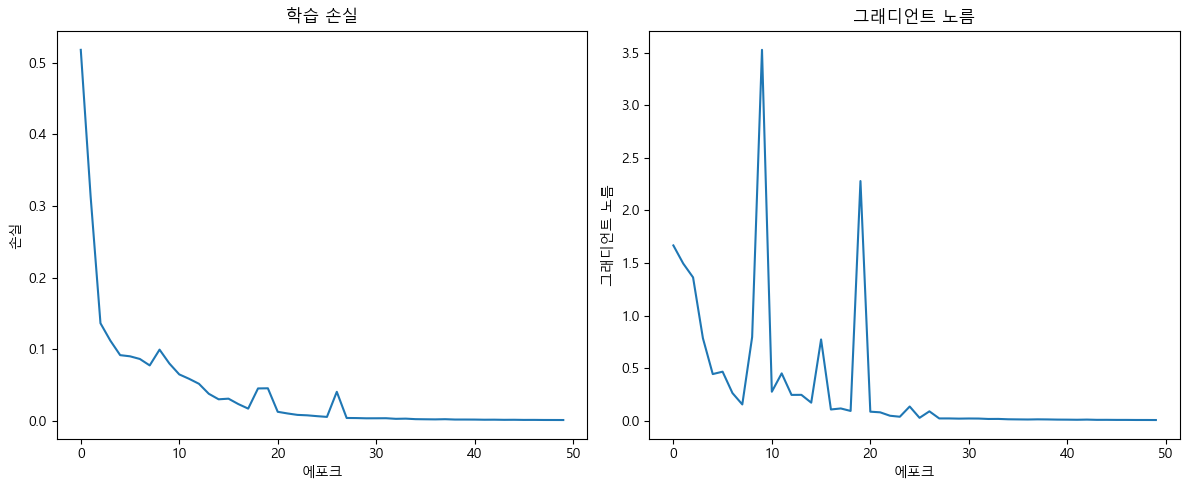

최종 테스트 정확도: 100.00%

행동 클래스:
0: 허리를 아치로 세움
1: 허리를 아치로 세우는 동작


In [6]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정
font_path = r'C:\Windows\Fonts\malgun.ttf'  # 맑은 고딕 폰트 경로
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()

def load_json_files(folder_path):
    data = []
    labels = []
    metadata = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.json'):
            with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as f:
                json_data = json.load(f)
                sequence = []
                for annotation in json_data['annotations']:
                    keypoints = extract_keypoints(annotation)
                    sequence.append(keypoints)
                data.append(sequence)
                labels.append(json_data['metadata']['inspect']['action'])
                metadata.append({
                    'painDisease': json_data['metadata']['inspect']['painDisease'],
                    'abnormalAction': json_data['metadata']['inspect']['abnormalAction'],
                    'emotion': json_data['metadata']['inspect']['emotion']
                })
    return data, labels, metadata

def extract_keypoints(annotation):
    keypoints = []
    for i in range(1, 16):
        kp = annotation['keypoints'].get(str(i))
        if kp:
            keypoints.extend([kp['x'], kp['y']])
        else:
            keypoints.extend([0, 0])
    return keypoints

def pad_sequences(sequences, max_length):
    padded_sequences = []
    for seq in sequences:
        if len(seq) > max_length:
            padded_sequences.append(seq[:max_length])
        else:
            padded_sequences.append(seq + [seq[-1]] * (max_length - len(seq)))
    return padded_sequences

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# 데이터 로드 및 전처리
folder_path = r'E:\LSTN_test\data\ARCH'
X, y, metadata = load_json_files(folder_path)

# 시퀀스 패딩
max_length = max(len(seq) for seq in X)
X_padded = pad_sequences(X, max_length)

# 레이블 인코딩
unique_actions = list(set(y))
action_to_index = {action: index for index, action in enumerate(unique_actions)}
y_encoded = [action_to_index[action] for action in y]

# 데이터 분할
X_train, X_test, y_train, y_test, metadata_train, metadata_test = train_test_split(
    X_padded, y_encoded, metadata, test_size=0.2, random_state=42)

# PyTorch 텐서로 변환
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# 데이터로더 생성
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 모델 초기화
input_size = 30  # 15개의 키포인트, 각각 x와 y 좌표
hidden_size = 64
num_layers = 2
num_classes = len(unique_actions)

model = LSTMModel(input_size, hidden_size, num_layers, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# 학습
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

losses = []
grad_norms = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    epoch_grad_norm = 0
    batch_count = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        
        # 그래디언트 노름 계산
        total_norm = 0
        for p in model.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        total_norm = total_norm ** 0.5
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_grad_norm += total_norm
        batch_count += 1
    
    avg_loss = epoch_loss / batch_count
    avg_grad_norm = epoch_grad_norm / batch_count
    losses.append(avg_loss)
    grad_norms.append(avg_grad_norm)
    
    # 검증
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
        
        accuracy = 100 * correct / total
        print(f'에포크 [{epoch+1}/{num_epochs}], 손실: {avg_loss:.4f}, 그래디언트 노름: {avg_grad_norm:.4f}, 정확도: {accuracy:.2f}%')

print("학습 완료!")

# 손실과 그래디언트 노름 그래프 그리기
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('학습 손실', fontproperties=font_prop)
plt.xlabel('에포크', fontproperties=font_prop)
plt.ylabel('손실', fontproperties=font_prop)

plt.subplot(1, 2, 2)
plt.plot(grad_norms)
plt.title('그래디언트 노름', fontproperties=font_prop)
plt.xlabel('에포크', fontproperties=font_prop)
plt.ylabel('그래디언트 노름', fontproperties=font_prop)

plt.tight_layout()
plt.show()

# 예측 함수
def predict_with_metadata(model, input_sequence, unique_actions, metadata):
    model.eval()
    with torch.no_grad():
        output = model(input_sequence)
        predicted_class = torch.argmax(output, dim=1).item()
        predicted_action = unique_actions[predicted_class]
        related_metadata = next((m for a, m in zip(unique_actions, metadata) if a == predicted_action), None)
    return predicted_action, related_metadata

# 최종 테스트 및 메타데이터 출력
model.eval()
correct = 0
total = 0
for i, (batch_X, batch_y) in enumerate(test_loader):
    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
    predicted_action, related_metadata = predict_with_metadata(model, batch_X, unique_actions, metadata_test[i*32:(i+1)*32])
    outputs = model(batch_X)
    _, predicted = torch.max(outputs.data, 1)
    total += batch_y.size(0)
    correct += (predicted == batch_y).sum().item()
    
    if i == 0:  # 첫 번째 배치의 첫 번째 샘플에 대해 출력
        print("\n예측 예시:")
        print(f"예측된 행동: {predicted_action}")
        print("관련 메타데이터:")
        print(f"  통증/질병 여부: {related_metadata['painDisease']}")
        print(f"  비정상 행동 여부: {related_metadata['abnormalAction']}")
        print(f"  감정: {related_metadata['emotion']}")

accuracy = 100 * correct / total
print(f'\n최종 테스트 정확도: {accuracy:.2f}%')

# 행동 클래스 출력
print("\n행동 클래스:")
for i, action in enumerate(unique_actions):
    print(f"{i}: {action}")

# 모델 저장
torch.save({
    'model_state_dict': model.state_dict(),
    'input_size': input_size,
    'hidden_size': hidden_size,
    'num_layers': num_layers,
    'num_classes': num_classes,
    'max_length': max_length,
    'unique_actions': unique_actions
}, 'lstm_model.pt')

print("\n모델이 'lstm_model.pt'로 저장되었습니다.")

Epochs:   3%|▎         | 1/30 [01:02<30:14, 62.56s/it]

에포크 [1/30], 손실: 2.8956, 그래디언트 노름: 3.8933, 정확도: 15.96%


Epochs:   7%|▋         | 2/30 [02:00<27:57, 59.91s/it]

에포크 [2/30], 손실: 2.8248, 그래디언트 노름: 6.7464, 정확도: 16.52%


Epochs:  10%|█         | 3/30 [02:58<26:29, 58.86s/it]

에포크 [3/30], 손실: 2.7956, 그래디언트 노름: 6.7552, 정확도: 16.28%


Epochs:  13%|█▎        | 4/30 [03:55<25:14, 58.25s/it]

에포크 [4/30], 손실: 2.7597, 그래디언트 노름: 8.2051, 정확도: 21.65%


Epochs:  17%|█▋        | 5/30 [04:53<24:09, 57.99s/it]

에포크 [5/30], 손실: 2.7322, 그래디언트 노름: 10.0655, 정확도: 21.23%


Epochs:  20%|██        | 6/30 [05:54<23:37, 59.05s/it]

에포크 [6/30], 손실: 2.7003, 그래디언트 노름: 10.1904, 정확도: 22.13%


Epochs:  23%|██▎       | 7/30 [07:05<24:07, 62.94s/it]

에포크 [7/30], 손실: 2.6900, 그래디언트 노름: 10.1398, 정확도: 20.95%


Epochs:  27%|██▋       | 8/30 [08:14<23:51, 65.06s/it]

에포크 [8/30], 손실: 2.6605, 그래디언트 노름: 9.9680, 정확도: 23.12%


Epochs:  30%|███       | 9/30 [09:18<22:37, 64.63s/it]

에포크 [9/30], 손실: 2.6263, 그래디언트 노름: 11.5119, 정확도: 23.11%


Epochs:  33%|███▎      | 10/30 [10:20<21:14, 63.73s/it]

에포크 [10/30], 손실: 2.6109, 그래디언트 노름: 11.3192, 정확도: 23.70%


Epochs:  37%|███▋      | 11/30 [11:20<19:50, 62.64s/it]

에포크 [11/30], 손실: 2.5987, 그래디언트 노름: 12.2044, 정확도: 22.96%


Epochs:  40%|████      | 12/30 [12:23<18:52, 62.90s/it]

에포크 [12/30], 손실: 2.5762, 그래디언트 노름: 11.8350, 정확도: 23.54%


Epochs:  43%|████▎     | 13/30 [13:24<17:40, 62.37s/it]

에포크 [13/30], 손실: 2.5864, 그래디언트 노름: 10.8958, 정확도: 21.67%


Epochs:  47%|████▋     | 14/30 [14:26<16:31, 61.99s/it]

에포크 [14/30], 손실: 2.5697, 그래디언트 노름: 11.3361, 정확도: 24.66%


Epochs:  50%|█████     | 15/30 [15:27<15:25, 61.68s/it]

에포크 [15/30], 손실: 2.5250, 그래디언트 노름: 14.1631, 정확도: 25.32%


Epochs:  53%|█████▎    | 16/30 [16:31<14:35, 62.51s/it]

에포크 [16/30], 손실: 2.5320, 그래디언트 노름: 12.1453, 정확도: 25.64%


Epochs:  57%|█████▋    | 17/30 [17:36<13:43, 63.35s/it]

에포크 [17/30], 손실: 2.5346, 그래디언트 노름: 12.3297, 정확도: 25.73%


Epochs:  60%|██████    | 18/30 [18:42<12:49, 64.14s/it]

에포크 [18/30], 손실: 2.5002, 그래디언트 노름: 12.7816, 정확도: 25.82%


Epochs:  63%|██████▎   | 19/30 [19:45<11:42, 63.86s/it]

에포크 [19/30], 손실: 2.4723, 그래디언트 노름: 13.4435, 정확도: 27.68%


Epochs:  67%|██████▋   | 20/30 [20:50<10:40, 64.08s/it]

에포크 [20/30], 손실: 2.4566, 그래디언트 노름: 13.4106, 정확도: 27.63%


Epochs:  70%|███████   | 21/30 [21:55<09:39, 64.36s/it]

에포크 [21/30], 손실: 2.4563, 그래디언트 노름: 13.0004, 정확도: 26.77%


Epochs:  73%|███████▎  | 22/30 [23:02<08:41, 65.21s/it]

에포크 [22/30], 손실: 2.4511, 그래디언트 노름: 13.9994, 정확도: 27.24%


Epochs:  77%|███████▋  | 23/30 [24:09<07:39, 65.60s/it]

에포크 [23/30], 손실: 2.4695, 그래디언트 노름: 12.5201, 정확도: 27.52%


Epochs:  80%|████████  | 24/30 [25:16<06:36, 66.02s/it]

에포크 [24/30], 손실: 2.4548, 그래디언트 노름: 13.2105, 정확도: 25.91%


Epochs:  83%|████████▎ | 25/30 [26:26<05:35, 67.14s/it]

에포크 [25/30], 손실: 2.4496, 그래디언트 노름: 12.9332, 정확도: 26.12%


Epochs:  87%|████████▋ | 26/30 [27:36<04:33, 68.29s/it]

에포크 [26/30], 손실: 2.4398, 그래디언트 노름: 13.8775, 정확도: 26.58%


Epochs:  90%|█████████ | 27/30 [28:49<03:28, 69.46s/it]

에포크 [27/30], 손실: 2.4557, 그래디언트 노름: 16.4600, 정확도: 27.69%


Epochs:  93%|█████████▎| 28/30 [29:55<02:17, 68.58s/it]

에포크 [28/30], 손실: 2.4575, 그래디언트 노름: 14.0747, 정확도: 27.44%


Epochs:  97%|█████████▋| 29/30 [30:59<01:07, 67.28s/it]

에포크 [29/30], 손실: 2.4256, 그래디언트 노름: 12.3828, 정확도: 27.67%


Epochs: 100%|██████████| 30/30 [32:07<00:00, 64.24s/it]

에포크 [30/30], 손실: 2.4346, 그래디언트 노름: 12.1160, 정확도: 26.79%
학습 완료


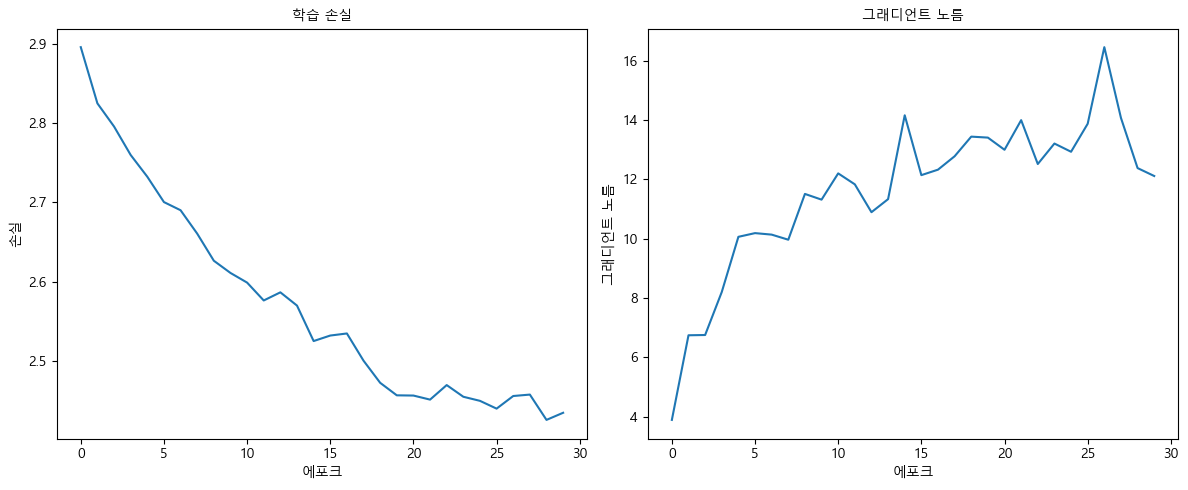


예측 예시:
예측된 행동: DOG_WALKRUN
관련 메타데이터:
  동물: DOG
  행동: WALKRUN
  통증/질병 여부: N
  비정상 행동 여부: N
  감정: 편안/안정

최종 테스트 정확도: 26.79%

행동 클래스:
0: CAT_ARCH
1: CAT_ARMSTRETCH
2: CAT_FOOTPUSH
3: CAT_GETDOWN
4: CAT_GROOMING
5: CAT_HEADING
6: CAT_LAYDOWN
7: CAT_LYING
8: CAT_ROLL
9: CAT_SITDOWN
10: CAT_TAILING
11: CAT_WALKRUN
12: DOG_BODYLOWER
13: DOG_BODYSCRATCH
14: DOG_BODYSHAKE
15: DOG_FEETUP
16: DOG_FOOTUP
17: DOG_HEADING
18: DOG_LYING
19: DOG_MOUNTING
20: DOG_SIT
21: DOG_TAILING
22: DOG_TAILLOW
23: DOG_TURN
24: DOG_WALKRUN

모델이 'lstm_model.pt'로 저장되었습니다.


In [11]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from tqdm import tqdm

# 한글 폰트 설정
font_path = r'C:\Windows\Fonts\malgun.ttf'  # 맑은 고딕 폰트 경로
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()

# 클래스 정의
CLASSES = {
    'CAT_ARCH': 0, 'CAT_ARMSTRETCH': 1, 'CAT_FOOTPUSH': 2, 'CAT_GETDOWN': 3, 'CAT_GROOMING': 4,
    'CAT_HEADING': 5, 'CAT_LAYDOWN': 6, 'CAT_LYING': 7, 'CAT_ROLL': 8, 'CAT_SITDOWN': 9,
    'CAT_TAILING': 10, 'CAT_WALKRUN': 11,
    'DOG_BODYLOWER': 12, 'DOG_BODYSCRATCH': 13, 'DOG_BODYSHAKE': 14, 'DOG_FEETUP': 15, 'DOG_FOOTUP': 16,
    'DOG_HEADING': 17, 'DOG_LYING': 18, 'DOG_MOUNTING': 19, 'DOG_SIT': 20, 'DOG_TAILING': 21,
    'DOG_TAILLOW': 22, 'DOG_TURN': 23, 'DOG_WALKRUN': 24
}

def load_json_files(base_folder):
    data = []
    labels = []
    metadata = []
    for animal in ['CAT', 'DOG']:
        animal_folder = os.path.join(base_folder, animal)
        for action_folder in os.listdir(animal_folder):
            action_path = os.path.join(animal_folder, action_folder)
            if os.path.isdir(action_path):
                class_name = f"{animal}_{action_folder.upper()}"
                if class_name in CLASSES:
                    for filename in os.listdir(action_path):
                        if filename.endswith('.json'):
                            with open(os.path.join(action_path, filename), 'r', encoding='utf-8') as f:
                                json_data = json.load(f)
                                sequence = []
                                for annotation in json_data['annotations']:
                                    keypoints = extract_keypoints(annotation)
                                    sequence.append(keypoints)
                                data.append(sequence)
                                labels.append(CLASSES[class_name])
                                metadata.append({
                                    'animal': animal,
                                    'action': action_folder,
                                    'painDisease': json_data['metadata']['inspect']['painDisease'],
                                    'abnormalAction': json_data['metadata']['inspect']['abnormalAction'],
                                    'emotion': json_data['metadata']['inspect']['emotion']
                                })
    return data, labels, metadata

def extract_keypoints(annotation):
    keypoints = []
    for i in range(1, 16):
        kp = annotation['keypoints'].get(str(i))
        if kp:
            keypoints.extend([kp['x'], kp['y']])
        else:
            keypoints.extend([0, 0])
    return keypoints

def pad_sequences(sequences, max_length):
    padded_sequences = []
    for seq in sequences:
        if len(seq) > max_length:
            padded_sequences.append(seq[:max_length])
        else:
            padded_sequences.append(seq + [seq[-1]] * (max_length - len(seq)))
    return padded_sequences

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# 데이터 로드 및 전처리
base_folder = r'E:\LSTN_test\json\Training'
X, y, metadata = load_json_files(base_folder)

# 시퀀스 패딩
max_length = max(len(seq) for seq in X)
X_padded = pad_sequences(X, max_length)

# 데이터 분할
X_train, X_test, y_train, y_test, metadata_train, metadata_test = train_test_split(
    X_padded, y, metadata, test_size=0.2, random_state=42)

# PyTorch 텐서로 변환
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# 데이터로더 생성
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 모델 초기화
input_size = 30  # 15개의 키포인트, 각각 x와 y 좌표
hidden_size = 64
num_layers = 2
num_classes = len(CLASSES)

model = LSTMModel(input_size, hidden_size, num_layers, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# 학습
num_epochs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

losses = []
grad_norms = []

for epoch in tqdm(range(num_epochs), desc="Epochs"):
    model.train()
    epoch_loss = 0
    epoch_grad_norm = 0
    batch_count = 0
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for batch_X, batch_y in progress_bar:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        
        # 그래디언트 노름 계산
        total_norm = 0
        for p in model.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        total_norm = total_norm ** 0.5
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_grad_norm += total_norm
        batch_count += 1
        
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = epoch_loss / batch_count
    avg_grad_norm = epoch_grad_norm / batch_count
    losses.append(avg_loss)
    grad_norms.append(avg_grad_norm)
    
    # 검증
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
        
        accuracy = 100 * correct / total
        print(f'에포크 [{epoch+1}/{num_epochs}], 손실: {avg_loss:.4f}, 그래디언트 노름: {avg_grad_norm:.4f}, 정확도: {accuracy:.2f}%')

print("학습 완료")

# 손실과 그래디언트 노름 그래프 그리기
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('학습 손실', fontproperties=font_prop)
plt.xlabel('에포크', fontproperties=font_prop)
plt.ylabel('손실', fontproperties=font_prop)

plt.subplot(1, 2, 2)
plt.plot(grad_norms)
plt.title('그래디언트 노름', fontproperties=font_prop)
plt.xlabel('에포크', fontproperties=font_prop)
plt.ylabel('그래디언트 노름', fontproperties=font_prop)

plt.tight_layout()
plt.show()

# 예측 함수
def predict_with_metadata(model, input_sequence, metadata):
    model.eval()
    with torch.no_grad():
        output = model(input_sequence)
        predicted_class = torch.argmax(output, dim=1).item()
        predicted_action = [k for k, v in CLASSES.items() if v == predicted_class][0]
        related_metadata = metadata[predicted_class]
    return predicted_action, related_metadata

# 최종 테스트 및 메타데이터 출력
model.eval()
correct = 0
total = 0
for i, (batch_X, batch_y) in enumerate(test_loader):
    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
    outputs = model(batch_X)
    _, predicted = torch.max(outputs.data, 1)
    total += batch_y.size(0)
    correct += (predicted == batch_y).sum().item()
    
    if i == 0:  # 첫 번째 배치의 첫 번째 샘플에 대해 출력
        predicted_action, related_metadata = predict_with_metadata(model, batch_X[0].unsqueeze(0), metadata_test)
        print("\n예측 예시:")
        print(f"예측된 행동: {predicted_action}")
        print("관련 메타데이터:")
        print(f"  동물: {related_metadata['animal']}")
        print(f"  행동: {related_metadata['action']}")
        print(f"  통증/질병 여부: {related_metadata['painDisease']}")
        print(f"  비정상 행동 여부: {related_metadata['abnormalAction']}")
        print(f"  감정: {related_metadata['emotion']}")

accuracy = 100 * correct / total
print(f'\n최종 테스트 정확도: {accuracy:.2f}%')

# 행동 클래스 출력
print("\n행동 클래스:")
for action, class_id in CLASSES.items():
    print(f"{class_id}: {action}")

# 모델 저장
torch.save({
    'model_state_dict': model.state_dict(),
    'input_size': input_size,
    'hidden_size': hidden_size,
    'num_layers': num_layers,
    'num_classes': num_classes,
    'max_length': max_length,
    'classes': CLASSES
}, 'lstm_model.pt')

print("\n모델이 'lstm_model.pt'로 저장되었습니다.")

C:\Users\Administrator\AppData\Local\Temp\ipykernel_5052\1841326735.py:83: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('lstm_model_cat_epoch_30.pt'

에포크 [31/50], 손실: 2.4108, 그래디언트 노름: 12.8478, 정확도: 26.14%


Additional Epochs:  10%|█         | 2/20 [02:20<20:58, 69.90s/it]

에포크 [32/50], 손실: 2.4147, 그래디언트 노름: 16.3689, 정확도: 27.81%


Additional Epochs:  15%|█▌        | 3/20 [03:37<20:41, 73.06s/it]

에포크 [33/50], 손실: 2.4274, 그래디언트 노름: 12.2864, 정확도: 27.12%


Additional Epochs:  20%|██        | 4/20 [04:44<18:53, 70.82s/it]

에포크 [34/50], 손실: 2.4178, 그래디언트 노름: 13.0233, 정확도: 28.30%


Additional Epochs:  25%|██▌       | 5/20 [05:47<16:59, 67.97s/it]

에포크 [35/50], 손실: 2.3910, 그래디언트 노름: 13.1784, 정확도: 28.88%


Additional Epochs:  30%|███       | 6/20 [06:50<15:28, 66.35s/it]

에포크 [36/50], 손실: 2.3764, 그래디언트 노름: 13.2837, 정확도: 27.91%


Additional Epochs:  35%|███▌      | 7/20 [07:55<14:16, 65.85s/it]

에포크 [37/50], 손실: 2.3906, 그래디언트 노름: 11.9612, 정확도: 27.04%


Additional Epochs:  40%|████      | 8/20 [09:09<13:39, 68.30s/it]

에포크 [38/50], 손실: 2.3829, 그래디언트 노름: 12.3298, 정확도: 27.19%


Additional Epochs:  45%|████▌     | 9/20 [10:40<13:49, 75.36s/it]

에포크 [39/50], 손실: 2.3961, 그래디언트 노름: 12.7500, 정확도: 28.84%


Additional Epochs:  50%|█████     | 10/20 [12:00<12:50, 77.01s/it]

에포크 [40/50], 손실: 2.3837, 그래디언트 노름: 12.4356, 정확도: 29.27%


Additional Epochs:  55%|█████▌    | 11/20 [13:10<11:12, 74.73s/it]

에포크 [41/50], 손실: 2.3736, 그래디언트 노름: 12.5646, 정확도: 28.49%


Additional Epochs:  60%|██████    | 12/20 [14:18<09:41, 72.71s/it]

에포크 [42/50], 손실: 2.3751, 그래디언트 노름: 12.9024, 정확도: 28.09%


Additional Epochs:  65%|██████▌   | 13/20 [15:33<08:34, 73.53s/it]

에포크 [43/50], 손실: 2.3766, 그래디언트 노름: 12.9188, 정확도: 28.73%


Additional Epochs:  70%|███████   | 14/20 [16:46<07:19, 73.26s/it]

에포크 [44/50], 손실: 2.3616, 그래디언트 노름: 12.5156, 정확도: 30.21%


Additional Epochs:  75%|███████▌  | 15/20 [17:55<05:59, 71.88s/it]

에포크 [45/50], 손실: 2.3728, 그래디언트 노름: 13.6386, 정확도: 27.18%


Additional Epochs:  80%|████████  | 16/20 [19:17<04:59, 74.95s/it]

에포크 [46/50], 손실: 2.3627, 그래디언트 노름: 12.9871, 정확도: 29.63%


Additional Epochs:  85%|████████▌ | 17/20 [20:36<03:48, 76.25s/it]

에포크 [47/50], 손실: 2.3494, 그래디언트 노름: 13.2161, 정확도: 29.93%


Additional Epochs:  90%|█████████ | 18/20 [21:51<02:31, 75.89s/it]

에포크 [48/50], 손실: 2.3458, 그래디언트 노름: 13.9087, 정확도: 29.05%


Additional Epochs:  95%|█████████▌| 19/20 [22:58<01:13, 73.10s/it]

에포크 [49/50], 손실: 2.3402, 그래디언트 노름: 12.9380, 정확도: 30.36%


Additional Epochs: 100%|██████████| 20/20 [24:05<00:00, 72.29s/it]

에포크 [50/50], 손실: 2.3511, 그래디언트 노름: 12.3661, 정확도: 28.98%
추가 학습 완료


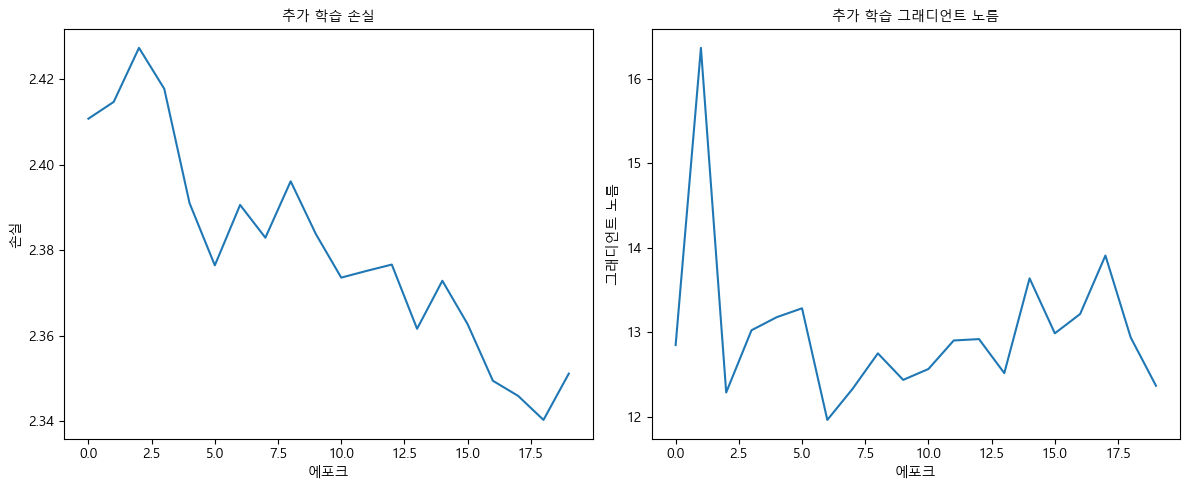


예측 예시:
예측된 행동: DOG_WALKRUN
관련 메타데이터:
  동물: DOG
  행동: WALKRUN
  통증/질병 여부: N
  비정상 행동 여부: N
  감정: 편안/안정

최종 테스트 정확도: 28.98%

행동 클래스:
0: CAT_ARCH
1: CAT_ARMSTRETCH
2: CAT_FOOTPUSH
3: CAT_GETDOWN
4: CAT_GROOMING
5: CAT_HEADING
6: CAT_LAYDOWN
7: CAT_LYING
8: CAT_ROLL
9: CAT_SITDOWN
10: CAT_TAILING
11: CAT_WALKRUN
12: DOG_BODYLOWER
13: DOG_BODYSCRATCH
14: DOG_BODYSHAKE
15: DOG_FEETUP
16: DOG_FOOTUP
17: DOG_HEADING
18: DOG_LYING
19: DOG_MOUNTING
20: DOG_SIT
21: DOG_TAILING
22: DOG_TAILLOW
23: DOG_TURN
24: DOG_WALKRUN

업데이트된 모델이 'lstm_model_additional.pt'로 저장되었습니다.


In [14]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from tqdm import tqdm

# 한글 폰트 설정
font_path = r'C:\Windows\Fonts\malgun.ttf'  # 맑은 고딕 폰트 경로
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()

def load_json_files(base_folder):
    data = []
    labels = []
    metadata = []
    for animal in ['CAT', 'DOG']:
        animal_folder = os.path.join(base_folder, animal)
        for action_folder in os.listdir(animal_folder):
            action_path = os.path.join(animal_folder, action_folder)
            if os.path.isdir(action_path):
                class_name = f"{animal}_{action_folder.upper()}"
                if class_name in CLASSES:
                    for filename in os.listdir(action_path):
                        if filename.endswith('.json'):
                            with open(os.path.join(action_path, filename), 'r', encoding='utf-8') as f:
                                json_data = json.load(f)
                                sequence = []
                                for annotation in json_data['annotations']:
                                    keypoints = extract_keypoints(annotation)
                                    sequence.append(keypoints)
                                data.append(sequence)
                                labels.append(CLASSES[class_name])
                                metadata.append({
                                    'animal': animal,
                                    'action': action_folder,
                                    'painDisease': json_data['metadata']['inspect']['painDisease'],
                                    'abnormalAction': json_data['metadata']['inspect']['abnormalAction'],
                                    'emotion': json_data['metadata']['inspect']['emotion']
                                })
    return data, labels, metadata

def extract_keypoints(annotation):
    keypoints = []
    for i in range(1, 16):
        kp = annotation['keypoints'].get(str(i))
        if kp:
            keypoints.extend([kp['x'], kp['y']])
        else:
            keypoints.extend([0, 0])
    return keypoints

def pad_sequences(sequences, max_length):
    padded_sequences = []
    for seq in sequences:
        if len(seq) > max_length:
            padded_sequences.append(seq[:max_length])
        else:
            padded_sequences.append(seq + [seq[-1]] * (max_length - len(seq)))
    return padded_sequences

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# 저장된 모델 불러오기
checkpoint = torch.load('lstm_model_cat_epoch_30.pt')
model = LSTMModel(checkpoint['input_size'], checkpoint['hidden_size'], 
                  checkpoint['num_layers'], checkpoint['num_classes'])
model.load_state_dict(checkpoint['model_state_dict'])
CLASSES = checkpoint['classes']
max_length = checkpoint['max_length']

# 데이터 준비
base_folder = r'E:\LSTN_test\json\Training'
X, y, metadata = load_json_files(base_folder)
X_padded = pad_sequences(X, max_length)

# 데이터 분할
X_train, X_test, y_train, y_test, metadata_train, metadata_test = train_test_split(
    X_padded, y, metadata, test_size=0.2, random_state=42)

# PyTorch 텐서로 변환
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# 데이터로더 생성
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 학습 파라미터 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# 추가 학습
additional_epochs = 20
total_epochs = 30 + additional_epochs  # 이전 30 에포크 + 추가 20 에포크

losses = []
grad_norms = []

for epoch in tqdm(range(30, total_epochs), desc="Additional Epochs"):
    model.train()
    epoch_loss = 0
    epoch_grad_norm = 0
    batch_count = 0
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{total_epochs}", leave=False)
    for batch_X, batch_y in progress_bar:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        
        # 그래디언트 노름 계산
        total_norm = 0
        for p in model.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        total_norm = total_norm ** 0.5
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_grad_norm += total_norm
        batch_count += 1
        
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = epoch_loss / batch_count
    avg_grad_norm = epoch_grad_norm / batch_count
    losses.append(avg_loss)
    grad_norms.append(avg_grad_norm)
    
    # 검증
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
        
        accuracy = 100 * correct / total
        print(f'에포크 [{epoch+1}/{total_epochs}], 손실: {avg_loss:.4f}, 그래디언트 노름: {avg_grad_norm:.4f}, 정확도: {accuracy:.2f}%')

print("추가 학습 완료")

# 손실과 그래디언트 노름 그래프 그리기
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('추가 학습 손실', fontproperties=font_prop)
plt.xlabel('에포크', fontproperties=font_prop)
plt.ylabel('손실', fontproperties=font_prop)

plt.subplot(1, 2, 2)
plt.plot(grad_norms)
plt.title('추가 학습 그래디언트 노름', fontproperties=font_prop)
plt.xlabel('에포크', fontproperties=font_prop)
plt.ylabel('그래디언트 노름', fontproperties=font_prop)

plt.tight_layout()
plt.show()

# 예측 함수
def predict_with_metadata(model, input_sequence, metadata):
    model.eval()
    with torch.no_grad():
        output = model(input_sequence)
        predicted_class = torch.argmax(output, dim=1).item()
        predicted_action = [k for k, v in CLASSES.items() if v == predicted_class][0]
        related_metadata = metadata[predicted_class]
    return predicted_action, related_metadata

# 최종 테스트 및 메타데이터 출력
model.eval()
correct = 0
total = 0
for i, (batch_X, batch_y) in enumerate(test_loader):
    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
    outputs = model(batch_X)
    _, predicted = torch.max(outputs.data, 1)
    total += batch_y.size(0)
    correct += (predicted == batch_y).sum().item()
    
    if i == 0:  # 첫 번째 배치의 첫 번째 샘플에 대해 출력
        predicted_action, related_metadata = predict_with_metadata(model, batch_X[0].unsqueeze(0), metadata_test)
        print("\n예측 예시:")
        print(f"예측된 행동: {predicted_action}")
        print("관련 메타데이터:")
        print(f"  동물: {related_metadata['animal']}")
        print(f"  행동: {related_metadata['action']}")
        print(f"  통증/질병 여부: {related_metadata['painDisease']}")
        print(f"  비정상 행동 여부: {related_metadata['abnormalAction']}")
        print(f"  감정: {related_metadata['emotion']}")

accuracy = 100 * correct / total
print(f'\n최종 테스트 정확도: {accuracy:.2f}%')

# 행동 클래스 출력
print("\n행동 클래스:")
for action, class_id in CLASSES.items():
    print(f"{class_id}: {action}")

# 업데이트된 모델 저장
torch.save({
    'model_state_dict': model.state_dict(),
    'input_size': checkpoint['input_size'],
    'hidden_size': checkpoint['hidden_size'],
    'num_layers': checkpoint['num_layers'],
    'num_classes': checkpoint['num_classes'],
    'max_length': max_length,
    'classes': CLASSES
}, 'lstm_model_additional.pt')

print("\n업데이트된 모델이 'lstm_model_additional.pt'로 저장되었습니다.")

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# 모델 예측
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

# 클래스별 성능 보고서
class_names = list(CLASSES.keys())
print(classification_report(all_labels, all_predictions, target_names=class_names))

# 혼동 행렬
conf_matrix = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(conf_matrix)

                 precision    recall  f1-score   support

       CAT_ARCH       0.00      0.00      0.00        32
 CAT_ARMSTRETCH       0.22      0.04      0.07       591
   CAT_FOOTPUSH       0.00      0.00      0.00       152
    CAT_GETDOWN       0.00      0.00      0.00       211
   CAT_GROOMING       0.46      0.43      0.44      1046
    CAT_HEADING       0.00      0.00      0.00       164
    CAT_LAYDOWN       0.18      0.04      0.06       356
      CAT_LYING       0.28      0.04      0.07       188
       CAT_ROLL       0.23      0.03      0.06       144
    CAT_SITDOWN       0.29      0.08      0.13       287
    CAT_TAILING       0.22      0.39      0.28       618
    CAT_WALKRUN       0.06      0.00      0.01       488
  DOG_BODYLOWER       0.22      0.26      0.24      1197
DOG_BODYSCRATCH       0.00      0.00      0.00       254
  DOG_BODYSHAKE       0.00      0.00      0.00       263
     DOG_FEETUP       0.37      0.41      0.39       560
     DOG_FOOTUP       0.33    

c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

## 데이터 증강

In [17]:
%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\users\administrator\appdata\local\programs\python\python312\lib\site-packages\torchlight-1.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [21]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from tqdm import tqdm
from imblearn.over_sampling import SMOTE

# 한글 폰트 설정
font_path = r'C:\Windows\Fonts\malgun.ttf'
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()

# 클래스 정의
CLASSES = {
    'CAT_ARCH': 0, 'CAT_ARMSTRETCH': 1, 'CAT_FOOTPUSH': 2, 'CAT_GETDOWN': 3, 'CAT_GROOMING': 4,
    'CAT_HEADING': 5, 'CAT_LAYDOWN': 6, 'CAT_LYING': 7, 'CAT_ROLL': 8, 'CAT_SITDOWN': 9,
    'CAT_TAILING': 10, 'CAT_WALKRUN': 11,
    'DOG_BODYLOWER': 12, 'DOG_BODYSCRATCH': 13, 'DOG_BODYSHAKE': 14, 'DOG_FEETUP': 15, 'DOG_FOOTUP': 16,
    'DOG_HEADING': 17, 'DOG_LYING': 18, 'DOG_MOUNTING': 19, 'DOG_SIT': 20, 'DOG_TAILING': 21,
    'DOG_TAILLOW': 22, 'DOG_TURN': 23, 'DOG_WALKRUN': 24
}

def load_json_files(base_folder):
    data = []
    labels = []
    metadata = []
    for animal in ['CAT', 'DOG']:
        animal_folder = os.path.join(base_folder, animal)
        for action_folder in os.listdir(animal_folder):
            action_path = os.path.join(animal_folder, action_folder)
            if os.path.isdir(action_path):
                class_name = f"{animal}_{action_folder.upper()}"
                if class_name in CLASSES:
                    for filename in os.listdir(action_path):
                        if filename.endswith('.json'):
                            with open(os.path.join(action_path, filename), 'r', encoding='utf-8') as f:
                                json_data = json.load(f)
                                sequence = []
                                for annotation in json_data['annotations']:
                                    keypoints = extract_keypoints(annotation)
                                    sequence.append(keypoints)
                                data.append(sequence)
                                labels.append(CLASSES[class_name])
                                metadata.append({
                                    'animal': animal,
                                    'action': action_folder,
                                    'painDisease': json_data['metadata']['inspect']['painDisease'],
                                    'abnormalAction': json_data['metadata']['inspect']['abnormalAction'],
                                    'emotion': json_data['metadata']['inspect']['emotion']
                                })
    return data, labels, metadata

def extract_keypoints(annotation):
    keypoints = []
    for i in range(1, 16):
        kp = annotation['keypoints'].get(str(i))
        if kp:
            keypoints.extend([kp['x'], kp['y']])
        else:
            keypoints.extend([0, 0])
    return keypoints

def pad_sequences(sequences, max_length):
    padded_sequences = []
    for seq in sequences:
        if len(seq) > max_length:
            padded_sequences.append(seq[:max_length])
        else:
            padded_sequences.append(seq + [seq[-1]] * (max_length - len(seq)))
    return padded_sequences

def augment_sequence(sequence):
    augmented = np.array(sequence).copy()
    num_frames, num_features = augmented.shape
    
    # 시간 왜곡
    time_warp = np.random.normal(loc=1.0, scale=0.1, size=(num_frames,))
    time_warp = np.cumsum(time_warp)
    new_frames = np.linspace(0, time_warp[-1], num_frames)
    
    # 각 특징(x, y 좌표)에 대해 개별적으로 보간
    for i in range(num_features):
        augmented[:, i] = np.interp(new_frames, time_warp, augmented[:, i])
    
    # 노이즈 추가
    noise = np.random.normal(0, 0.05, augmented.shape)
    augmented += noise
    
    return augmented

class ImprovedLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(ImprovedLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.5)
        self.fc1 = nn.Linear(hidden_size, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc1(out[:, -1, :])
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

# 데이터 로드 및 전처리
base_folder = r'E:\LSTN_test\json\Training'
X, y, metadata = load_json_files(base_folder)

# 시퀀스 패딩
max_length = max(len(seq) for seq in X)
X_padded = pad_sequences(X, max_length)

# 데이터 분할
X_train, X_test, y_train, y_test, metadata_train, metadata_test = train_test_split(
    X_padded, y, metadata, test_size=0.2, random_state=42)

# 데이터 증강
X_train_augmented = []
y_train_augmented = []
for seq, label in zip(X_train, y_train):
    X_train_augmented.append(seq)
    y_train_augmented.append(label)
    # 각 시퀀스에 대해 1개의 증강된 버전 생성
    X_train_augmented.append(augment_sequence(seq))
    y_train_augmented.append(label)

# PyTorch 텐서로 변환
X_train = torch.FloatTensor(X_train_augmented)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train_augmented)
y_test = torch.LongTensor(y_test)

# 데이터로더 생성
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 모델 초기화
input_size = 30
hidden_size = 128
num_layers = 3
num_classes = len(CLASSES)

model = ImprovedLSTMModel(input_size, hidden_size, num_layers, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 클래스 가중치 계산
class_weights = compute_class_weight('balanced', classes=np.unique(y_train.numpy()), y=y_train.numpy())
class_weights = torch.FloatTensor(class_weights).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)

# 학습
num_epochs = 10
losses = []
accuracies = []

for epoch in tqdm(range(num_epochs), desc="Epochs"):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)
    
    # 검증
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    
    accuracy = 100 * correct / total
    accuracies.append(accuracy)
    
    print(f'에포크 [{epoch+1}/{num_epochs}], 손실: {avg_loss:.4f}, 정확도: {accuracy:.2f}%')
    
    scheduler.step(avg_loss)

print("학습 완료")

# 그래프 그리기
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('학습 손실', fontproperties=font_prop)
plt.xlabel('에포크', fontproperties=font_prop)
plt.ylabel('손실', fontproperties=font_prop)

plt.subplot(1, 2, 2)
plt.plot(accuracies)
plt.title('검증 정확도', fontproperties=font_prop)
plt.xlabel('에포크', fontproperties=font_prop)
plt.ylabel('정확도 (%)', fontproperties=font_prop)

plt.tight_layout()
plt.show()

# 최종 테스트
model.eval()
all_predictions = []
all_labels = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

# 분류 보고서 출력
from sklearn.metrics import classification_report
print(classification_report(all_labels, all_predictions, target_names=list(CLASSES.keys())))

# 모델 저장
torch.save({
    'model_state_dict': model.state_dict(),
    'input_size': input_size,
    'hidden_size': hidden_size,
    'num_layers': num_layers,
    'num_classes': num_classes,
    'max_length': max_length,
    'classes': CLASSES
}, 'improved_lstm_model.pt')

print("\n'improved_lstm_model.pt'로 저장되었습니다.")